In [1]:
#Suppress warnings...
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install langdetect
!pip install googletrans==4.0.0-rc1

!pip install textblob
#!pip install xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=6287fa805f0cccbbe7bc842cf675cacb271caed464da46e68767d6b480f45320
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.9 MB/s eta 

Listings Data Processing for Descriptive Statitics

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD

from googletrans import Translator
from langdetect import detect

from textblob import TextBlob

import seaborn as sns # Import seaborn for heatmap
import matplotlib.pyplot as plt # Import matplotlib for plotting

import xgboost as xgb

In [4]:
# import listing datasets for Buenos Aires
listings_url = 'https://data.insideairbnb.com/argentina/ciudad-aut%C3%B3noma-de-buenos-aires/buenos-aires/2024-08-25/data/listings.csv.gz'


# Load the datasets into DataFrames
listings_df = pd.read_csv(listings_url, compression='gzip')
listings_df = listings_df[['id','price','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','minimum_nights','maximum_nights','has_availability','number_of_reviews','instant_bookable','review_scores_rating']]
listings_df.head() #Getting Headers

,id,price,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,has_availability,number_of_reviews,instant_bookable,review_scores_rating
0,11508,"$60,390.00",-34.581840,-58.424150,Entire condo,Entire home/apt,2,1.0,1.0,1.0,3,1125,t,42,f,4.81
1,14222,"$37,001.00",-34.586170,-58.410360,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,7,40,t,120,f,4.76
2,15074,NaN,-34.538920,-58.465990,Private room in rental unit,Private room,1,NaN,NaN,NaN,29,730,NaN,0,f,NaN
3,16695,"$47,275.00",-34.614390,-58.376110,Entire loft,Entire home/apt,4,1.0,1.0,1.0,2,1125,t,45,t,4.28
4,20062,"$95,681.00",-34.581848,-58.441605,Entire rental unit,Entire home/apt,4,1.5,2.0,2.0,2,365,t,321,f,4.93


In [5]:
 # Check for missing values.
listings_df.isnull().sum()

,0
id,0
price,2956
latitude,0
longitude,0
property_type,0
room_type,0
accommodates,0
bathrooms,2956
bedrooms,610
beds,2955


In [6]:
#Handling missing data
listings_df.dropna(subset=['price'], inplace=True) #dropping records for missing values in prices
listings_df['number_of_reviews'].fillna(0, inplace=True) #filling in 0 for missing values in number of reviews, and has availability
listings_df['has_availability'].fillna(0, inplace=True)
listings_df['bathrooms'].fillna(listings_df['bathrooms'].mode()[0], inplace=True) #replacing with mode for bathrooms with missing values
listings_df['bedrooms'].fillna(listings_df['bedrooms'].mode()[0], inplace=True) #replacing with mode for bedrooms with missing values
listings_df['beds'].fillna(listings_df['beds'].mode()[0], inplace=True) #replacing with mode for bedrooms with missing values

#listings_df['review_scores_rating'].fillna(0, inplace=True) # Fill missing review values with 0 and adding a new variable 'has_review_scores'
listings_df['review_scores_rating'].fillna(0, inplace=True)
listings_df['number_of_reviews'] = (listings_df['review_scores_rating'] > 0).astype(int)


In [7]:
 # Check for missing values.
listings_df.isnull().sum()

,0
id,0
price,0
latitude,0
longitude,0
property_type,0
room_type,0
accommodates,0
bathrooms,0
bedrooms,0
beds,0


In [8]:
#Descriptive Statistics for basic Listing data
# Descriptive statistics
Desc_Listings=listings_df[['bathrooms', 'bedrooms','beds','review_scores_rating', 'minimum_nights', 'maximum_nights']]
Desc_Listings.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,33851.0,1.231278,0.631353,0.0,1.0,1.00,1.00,22.0
bedrooms,33851.0,1.160202,0.877323,0.0,1.0,1.00,1.00,22.0
beds,33851.0,1.888157,1.562282,0.0,1.0,1.00,2.00,36.0
review_scores_rating,33851.0,3.965006,1.832056,0.0,4.5,4.83,4.98,5.0
minimum_nights,33851.0,4.876636,16.896798,1.0,1.0,2.00,3.00,730.0
maximum_nights,33851.0,427.576349,663.000699,1.0,90.0,365.00,365.00,99999.0


In [9]:
listings_df.head()

,id,price,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,has_availability,number_of_reviews,instant_bookable,review_scores_rating
0,11508,"$60,390.00",-34.581840,-58.424150,Entire condo,Entire home/apt,2,1.0,1.0,1.0,3,1125,t,1,f,4.81
1,14222,"$37,001.00",-34.586170,-58.410360,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,7,40,t,1,f,4.76
3,16695,"$47,275.00",-34.614390,-58.376110,Entire loft,Entire home/apt,4,1.0,1.0,1.0,2,1125,t,1,t,4.28
4,20062,"$95,681.00",-34.581848,-58.441605,Entire rental unit,Entire home/apt,4,1.5,2.0,2.0,2,365,t,1,f,4.93
6,24713,"$26,170.00",-34.602540,-58.378110,Entire rental unit,Entire home/apt,3,1.0,1.0,2.0,1,10,t,1,f,4.66


In [10]:
#Geomap for identifying popular airbnb locations using a sample
sample_size = 1000  # Define your sample size
sampled_listings = listings_df.sample(n=sample_size, random_state=42)


!pip install folium

import folium

# Create a map centered on Buenos Aires
buenos_aires_map = folium.Map(location=[-34.6037, -58.3816], zoom_start=12)  # Adjust coordinates and zoom as needed

# Add markers for each listing
for index, row in sampled_listings.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Price: {row['price']}",  # Customize popup content
        icon=folium.Icon(color='red', icon='home'),  # Customize marker icon
    ).add_to(buenos_aires_map)

# Generate the map
buenos_aires_map


### **HISTOGRAMS**

### Categorical Data

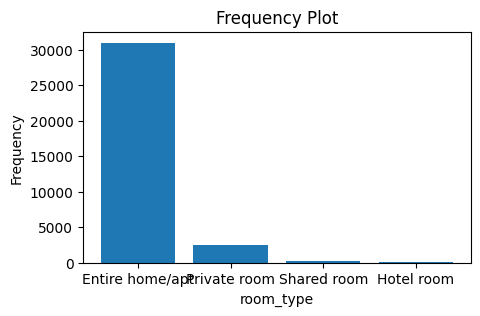

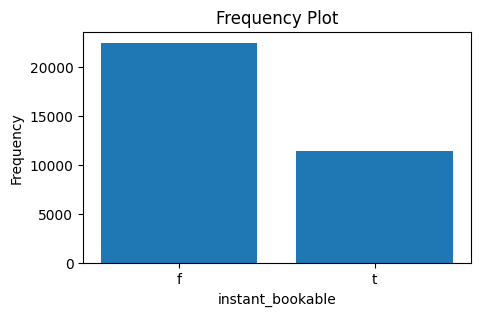

In [11]:
categorical = ['room_type', 'instant_bookable']
for i in categorical:
  plt.figure(figsize=(5, 3))
  category_counts = listings_df[i].value_counts()
  plt.bar(category_counts.index, category_counts.values)
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.title('Frequency Plot')
  plt.show()

  # plt.title('Distribution of ' + i)
  # plt.xlabel('Number of Bedrooms')
  # plt.ylabel('Count')
  # plt.show()

### Descriptive Data

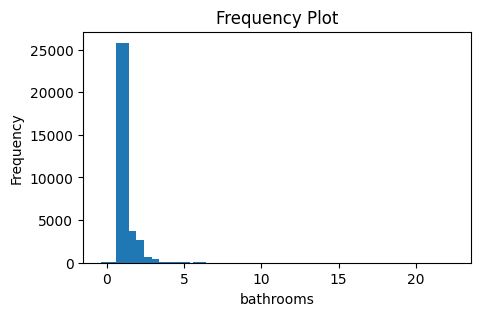

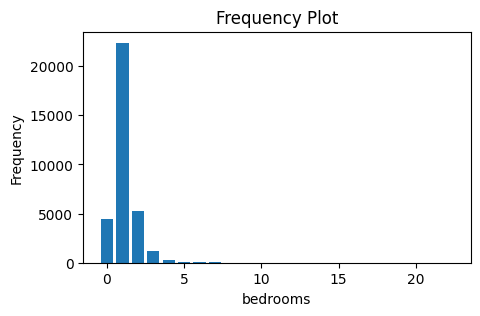

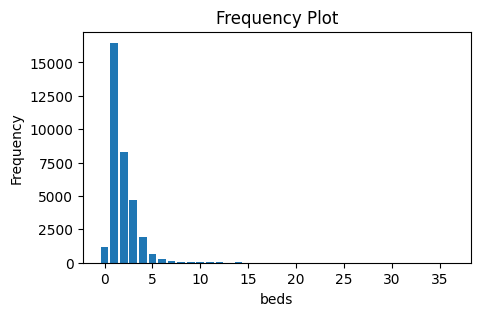

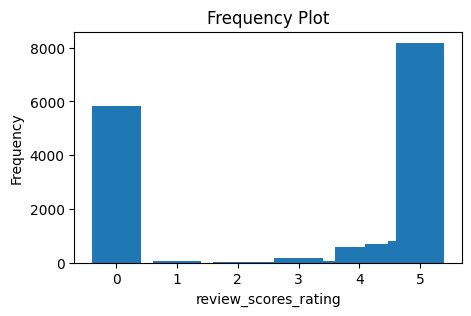

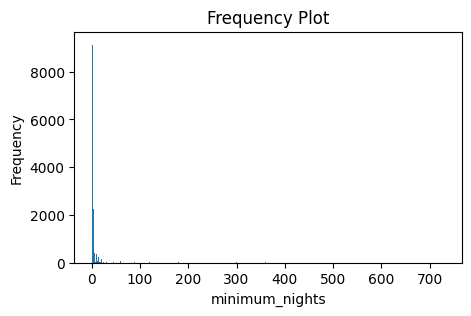

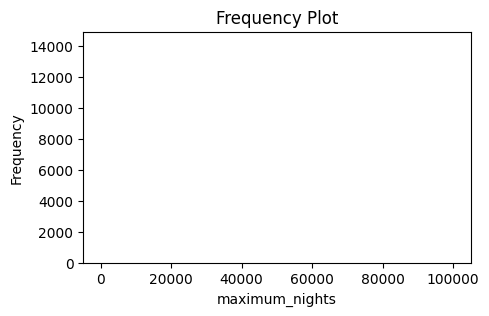

In [12]:
desc = ['bathrooms', 'bedrooms','beds','review_scores_rating', 'minimum_nights', 'maximum_nights']
for i in desc:
  plt.figure(figsize=(5, 3))
  category_counts = listings_df[i].value_counts()
  plt.bar(category_counts.index, category_counts.values)
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.title('Frequency Plot')
  plt.show()

In [13]:
# Perform one-hot encoding
encoded_df = pd.get_dummies(listings_df, columns=['property_type', 'room_type'], prefix=['property', 'room'])
encoded_df.head()

,id,price,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,...,property_Shared room in serviced apartment,property_Shared room in tent,property_Shared room in townhouse,property_Shared room in villa,property_Tiny home,property_Tower,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room
0,11508,"$60,390.00",-34.581840,-58.424150,2,1.0,1.0,1.0,3,1125,...,False,False,False,False,False,False,True,False,False,False
1,14222,"$37,001.00",-34.586170,-58.410360,2,1.0,1.0,1.0,7,40,...,False,False,False,False,False,False,True,False,False,False
3,16695,"$47,275.00",-34.614390,-58.376110,4,1.0,1.0,1.0,2,1125,...,False,False,False,False,False,False,True,False,False,False
4,20062,"$95,681.00",-34.581848,-58.441605,4,1.5,2.0,2.0,2,365,...,False,False,False,False,False,False,True,False,False,False
6,24713,"$26,170.00",-34.602540,-58.378110,3,1.0,1.0,2.0,1,10,...,False,False,False,False,False,False,True,False,False,False


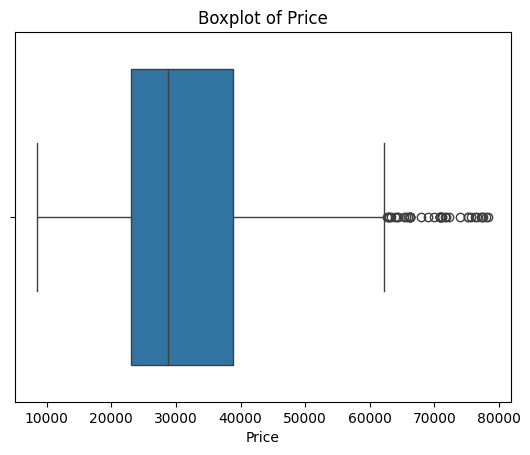

In [56]:
#Plotting a boxplot to visualize outliers in price
sns.boxplot(x=encoded_df['price'])
plt.title('Boxplot of Price')
plt.xlabel('Price')
plt.show()

### Reviews Data

In [14]:
# Data from reviews
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
reviews_url = 'https://data.insideairbnb.com/argentina/ciudad-aut%C3%B3noma-de-buenos-aires/buenos-aires/2024-08-25/data/reviews.csv.gz'
reviews_df = pd.read_csv(reviews_url, compression='gzip')
reviews_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,11508,1615861,2012-07-02,877808,Charlie,Amazing place!\r<br/>\r<br/>Location: short wa...
1,11508,3157005,2012-12-26,656077,Shaily,Really enjoyed Candela's recommendations and q...
2,11508,3281011,2013-01-05,2835998,Michiel,Candela and her colleague were very attentive ...
3,11508,6050019,2013-07-28,4600436,Tara,"The apartment was in a beautiful, modern build..."
4,11508,9328455,2013-12-22,3130017,Simon,My stay at Candela's apartment was very enjoya...


In [15]:
#Checking for missing values
reviews_df.isnull().sum()

,0
listing_id,0
id,0
date,0
reviewer_id,0
reviewer_name,0
comments,36


In [16]:
#dropping records for missing values in reviews
reviews_df.dropna(subset=['comments'], inplace=True)

In [17]:
#Checking for missing value
reviews_df.isnull().sum()

,0
listing_id,0
id,0
date,0
reviewer_id,0
reviewer_name,0
comments,0


## Data Preprocessing

In [18]:
def translate_comment(comment):
    count=0
    try:
        detected_lang = detect(comment)
        if detected_lang != 'en':
            # print(f"Translating from {detected_lang} to English...")  # Add this line for visibility
            translator = Translator()
            translated = translator.translate(comment, dest='en')
            return translated.text
        else:
            return comment  # Return as is if already in English
    except Exception as e:
        print(f"Error during language detection or translation: {e}")
        return comment

In [19]:
len(reviews_df)

899461

In [20]:
len(listings_df)

33851

In [21]:
# sample_size = int(len(listings_df)/4)
sample_size = 1000
reviews_df = reviews_df.sample(n=sample_size, random_state=42)

In [22]:
reviews_df['translated_comments'] = reviews_df['comments'].apply(translate_comment)
reviews_df.head()

Error during language detection or translation: No features in text.
Error during language detection or translation: No features in text.
Error during language detection or translation: No features in text.
Error during language detection or translation: No features in text.
Error during language detection or translation: No features in text.
Error during language detection or translation: No features in text.
Error during language detection or translation: No features in text.
Error during language detection or translation: No features in text.


,listing_id,id,date,reviewer_id,reviewer_name,comments,translated_comments
682684,805730817311808441,883346919002697756,2023-05-03,510237414,Cesar,"Sin duda alguna volvería, la atención espectac...","Without a doubt, the spectacular attention, wi..."
202696,20844881,869523917250539200,2023-04-14,503156539,Michael,"Tuve una muy buena atención, María siempre me ...","I had a very good attention, Maria always answ..."
360204,35570485,546323946,2019-10-13,133301928,Agustina,Excelente lugar y cubre todas las necesidades,Excellent place and cover all needs
107850,8503251,345029968,2018-11-04,96325228,Leonardo,El departamento de Marcos es muy funcional par...,Marcos's department is very functional for tho...
521841,565840159307119675,969537977561367188,2023-08-30,173588948,Federico,todo bien,all good


In [23]:
len(reviews_df)

1000

In [24]:
reviews_df.isnull().sum()

,0
listing_id,0
id,0
date,0
reviewer_id,0
reviewer_name,0
comments,0
translated_comments,0


In [25]:
# pre- processing function

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()


# Define the preprocessing function
def preprocess_text(text):
    if pd.isnull(text):
        return ''
    # Remove URLs, non-letters, and convert to lowercase
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()

    # Tokenize and remove stopwords
    tokens = text.split()
    stop_words = set(stopwords.words('english'))

    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens if word not in stop_words and word not in string.punctuation]

    return ' '.join(tokens)

In [26]:
# pre-process comments
reviews_df['cleaned_comments'] = reviews_df['translated_comments'].apply(preprocess_text)

In [27]:
merged_df = pd.merge(listings_df, reviews_df, left_on='id',right_on='listing_id')
merged_df.head()

,id_x,price,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,instant_bookable,review_scores_rating,listing_id,id_y,date,reviewer_id,reviewer_name,comments,translated_comments,cleaned_comments
0,14222,"$37,001.00",-34.586170,-58.410360,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,...,f,4.76,14222,5846614,2013-07-19,6845781,Patsy,The happy house was the perfect place to spend...,The happy house was the perfect place to spend...,happy house perfect place spend visit buenos a...
1,24713,"$26,170.00",-34.602540,-58.378110,Entire rental unit,Entire home/apt,3,1.0,1.0,2.0,...,f,4.66,24713,93387290,2016-08-12,34759230,Maria Lia,Very central and good price as within easy rea...,Very central and good price as within easy rea...,central good price within easy reach everythin...
2,42450,"$80,368.00",-34.615780,-58.371750,Entire condo,Entire home/apt,4,2.0,2.0,2.0,...,f,4.83,42450,981126375768648078,2023-09-15,64139202,Weiping,我们两家四人入住，交通便利，生活方便，特别是Miss Drisel接待我们，特意教如何使用煤...,"The two of us are in the same place, convenien...",two us place convenient transportation conveni...
3,61282,"$34,984.00",-34.553960,-58.467530,Entire loft,Entire home/apt,2,2.0,1.0,1.0,...,f,4.88,61282,48232076,2015-09-24,44254417,Luiz Paulo,O loft do alejando é exatamente como descrito ...,The Alejando Loft is exactly as described and ...,alejando loft exactly describe show photosive ...
4,69063,"$25,803.00",-34.595348,-58.396835,Entire rental unit,Entire home/apt,4,1.0,1.0,3.0,...,t,4.67,69063,1848771,2012-07-31,889000,Miguel,"todo super, el depto es muy comodo y super bie...","All super, the apartment is very comfortable a...",super apartment comfortable super well locate ...


In [28]:
merged_df.isnull().sum()

,0
id_x,0
price,0
latitude,0
longitude,0
property_type,0
room_type,0
accommodates,0
bathrooms,0
bedrooms,0
beds,0


In [29]:
len(merged_df)

955

In [30]:
def get_sentiment(text):
  if isinstance(text, str):  # Check if text is a string
    blob = TextBlob(text)
    return blob.sentiment.polarity
  else:
    return np.nan  # Handle non-string values (e.g., NaN)

In [31]:
merged_df['sentiment'] = merged_df['cleaned_comments'].apply(get_sentiment)
merged_df.head()

,id_x,price,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,review_scores_rating,listing_id,id_y,date,reviewer_id,reviewer_name,comments,translated_comments,cleaned_comments,sentiment
0,14222,"$37,001.00",-34.586170,-58.410360,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,...,4.76,14222,5846614,2013-07-19,6845781,Patsy,The happy house was the perfect place to spend...,The happy house was the perfect place to spend...,happy house perfect place spend visit buenos a...,0.648148
1,24713,"$26,170.00",-34.602540,-58.378110,Entire rental unit,Entire home/apt,3,1.0,1.0,2.0,...,4.66,24713,93387290,2016-08-12,34759230,Maria Lia,Very central and good price as within easy rea...,Very central and good price as within easy rea...,central good price within easy reach everythin...,0.297619
2,42450,"$80,368.00",-34.615780,-58.371750,Entire condo,Entire home/apt,4,2.0,2.0,2.0,...,4.83,42450,981126375768648078,2023-09-15,64139202,Weiping,我们两家四人入住，交通便利，生活方便，特别是Miss Drisel接待我们，特意教如何使用煤...,"The two of us are in the same place, convenien...",two us place convenient transportation conveni...,0.075000
3,61282,"$34,984.00",-34.553960,-58.467530,Entire loft,Entire home/apt,2,2.0,1.0,1.0,...,4.88,61282,48232076,2015-09-24,44254417,Luiz Paulo,O loft do alejando é exatamente como descrito ...,The Alejando Loft is exactly as described and ...,alejando loft exactly describe show photosive ...,0.650000
4,69063,"$25,803.00",-34.595348,-58.396835,Entire rental unit,Entire home/apt,4,1.0,1.0,3.0,...,4.67,69063,1848771,2012-07-31,889000,Miguel,"todo super, el depto es muy comodo y super bie...","All super, the apartment is very comfortable a...",super apartment comfortable super well locate ...,0.355556


In [32]:
#categorizing sentiments

def categorize_sentiment(score):
  if score >= 0.8:
    return "positive"
  elif score >= 0.0:  # Values between 0.0 and 0.8
    return "moderate"
  else:
    return "negative"

In [33]:
merged_df['sentiment_category'] = merged_df['sentiment'].apply(categorize_sentiment)
merged_df.head()

,id_x,price,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,listing_id,id_y,date,reviewer_id,reviewer_name,comments,translated_comments,cleaned_comments,sentiment,sentiment_category
0,14222,"$37,001.00",-34.586170,-58.410360,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,...,14222,5846614,2013-07-19,6845781,Patsy,The happy house was the perfect place to spend...,The happy house was the perfect place to spend...,happy house perfect place spend visit buenos a...,0.648148,moderate
1,24713,"$26,170.00",-34.602540,-58.378110,Entire rental unit,Entire home/apt,3,1.0,1.0,2.0,...,24713,93387290,2016-08-12,34759230,Maria Lia,Very central and good price as within easy rea...,Very central and good price as within easy rea...,central good price within easy reach everythin...,0.297619,moderate
2,42450,"$80,368.00",-34.615780,-58.371750,Entire condo,Entire home/apt,4,2.0,2.0,2.0,...,42450,981126375768648078,2023-09-15,64139202,Weiping,我们两家四人入住，交通便利，生活方便，特别是Miss Drisel接待我们，特意教如何使用煤...,"The two of us are in the same place, convenien...",two us place convenient transportation conveni...,0.075000,moderate
3,61282,"$34,984.00",-34.553960,-58.467530,Entire loft,Entire home/apt,2,2.0,1.0,1.0,...,61282,48232076,2015-09-24,44254417,Luiz Paulo,O loft do alejando é exatamente como descrito ...,The Alejando Loft is exactly as described and ...,alejando loft exactly describe show photosive ...,0.650000,moderate
4,69063,"$25,803.00",-34.595348,-58.396835,Entire rental unit,Entire home/apt,4,1.0,1.0,3.0,...,69063,1848771,2012-07-31,889000,Miguel,"todo super, el depto es muy comodo y super bie...","All super, the apartment is very comfortable a...",super apartment comfortable super well locate ...,0.355556,moderate


In [34]:
# Convert 'instant_bookable' to numeric (0 for False, 1 for True) before calculating correlation
encoded_df['instant_bookable', 'has_availability'] = merged_df['instant_bookable'].map({'f': 0, 't': 1})

# Perform one-hot encoding
encoded_df = pd.get_dummies(merged_df, columns=['property_type', 'room_type','instant_bookable','sentiment_category'], prefix=['property', 'room','instant','sentiment'])
encoded_df.head()

,id_x,price,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,...,property_Shared room in hostel,property_Shared room in villa,room_Entire home/apt,room_Private room,room_Shared room,instant_f,instant_t,sentiment_moderate,sentiment_negative,sentiment_positive
0,14222,"$37,001.00",-34.586170,-58.410360,2,1.0,1.0,1.0,7,40,...,False,False,True,False,False,True,False,True,False,False
1,24713,"$26,170.00",-34.602540,-58.378110,3,1.0,1.0,2.0,1,10,...,False,False,True,False,False,True,False,True,False,False
2,42450,"$80,368.00",-34.615780,-58.371750,4,2.0,2.0,2.0,4,1125,...,False,False,True,False,False,True,False,True,False,False
3,61282,"$34,984.00",-34.553960,-58.467530,2,2.0,1.0,1.0,6,240,...,False,False,True,False,False,True,False,True,False,False
4,69063,"$25,803.00",-34.595348,-58.396835,4,1.0,1.0,3.0,1,365,...,False,False,True,False,False,False,True,True,False,False


In [35]:
encoded_df = encoded_df.drop(['comments', 'translated_comments', 'reviewer_name', 'reviewer_id', 'date', 'id_y', 'listing_id', 'id_x'], axis=1)

In [36]:
encoded_df.head()

,price,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,has_availability,...,property_Shared room in hostel,property_Shared room in villa,room_Entire home/apt,room_Private room,room_Shared room,instant_f,instant_t,sentiment_moderate,sentiment_negative,sentiment_positive
0,"$37,001.00",-34.586170,-58.410360,2,1.0,1.0,1.0,7,40,t,...,False,False,True,False,False,True,False,True,False,False
1,"$26,170.00",-34.602540,-58.378110,3,1.0,1.0,2.0,1,10,t,...,False,False,True,False,False,True,False,True,False,False
2,"$80,368.00",-34.615780,-58.371750,4,2.0,2.0,2.0,4,1125,t,...,False,False,True,False,False,True,False,True,False,False
3,"$34,984.00",-34.553960,-58.467530,2,2.0,1.0,1.0,6,240,t,...,False,False,True,False,False,True,False,True,False,False
4,"$25,803.00",-34.595348,-58.396835,4,1.0,1.0,3.0,1,365,t,...,False,False,True,False,False,False,True,True,False,False


In [37]:
# Converting boolean columns to numeric values
columns_to_convert = []

for i in encoded_df.columns:
  if encoded_df[i].dtype == 'bool':
    columns_to_convert.append(i)

encoded_df[columns_to_convert] = encoded_df[columns_to_convert].replace({True: 1, False: 0})
encoded_df['has_availability'] = encoded_df['has_availability'].replace({'t': 1, 'f': 0})

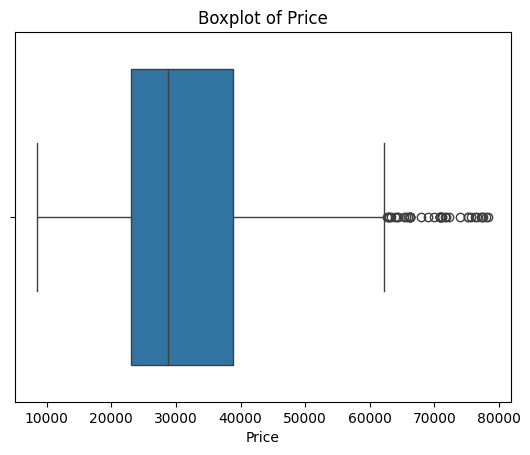

In [39]:
#Plotting a boxplot to visualize outliers in price
sns.boxplot(x=encoded_df['price'])
plt.title('Boxplot of Price')
plt.xlabel('Price')
plt.show()

In [38]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
# Convert 'price' to numeric (float) if it's not already
if encoded_df['price'].dtype == 'object':
    encoded_df['price'] = encoded_df['price'].str.replace('[\$,]', '', regex=True).astype(float)
else:
    print("The 'price' column is already numeric. Skipping string conversion.")
Q1 = encoded_df['price'].quantile(0.25)
Q3 = encoded_df['price'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile range

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
encoded_df = encoded_df[(encoded_df['price'] >= lower_bound) & (encoded_df['price'] <= upper_bound)]

Original size: (868, 44)


In [40]:
encoded_df.drop(['review_scores_rating', 'cleaned_comments'], axis=1, inplace=True)

In [41]:
encoded_df.head()

,price,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,has_availability,...,property_Shared room in hostel,property_Shared room in villa,room_Entire home/apt,room_Private room,room_Shared room,instant_f,instant_t,sentiment_moderate,sentiment_negative,sentiment_positive
0,37001.0,-34.586170,-58.410360,2,1.0,1.0,1.0,7,40,1,...,0,0,1,0,0,1,0,1,0,0
1,26170.0,-34.602540,-58.378110,3,1.0,1.0,2.0,1,10,1,...,0,0,1,0,0,1,0,1,0,0
3,34984.0,-34.553960,-58.467530,2,2.0,1.0,1.0,6,240,1,...,0,0,1,0,0,1,0,1,0,0
4,25803.0,-34.595348,-58.396835,4,1.0,1.0,3.0,1,365,1,...,0,0,1,0,0,0,1,1,0,0
5,21747.0,-34.594460,-58.395880,2,1.0,1.0,1.0,3,180,1,...,0,0,1,0,0,0,1,1,0,0


In [42]:
# PERFORMING FEATURE IMPORTANCE

from sklearn.ensemble import RandomForestClassifier

# Convert 'price' to numeric (float)
if encoded_df['price'].dtype == 'object':
    encoded_df['price'] = encoded_df['price'].str.replace('[\$,]', '', regex=True).astype(float)
else:
    print("The 'price' column is already numeric. Skipping string conversion.")

x = encoded_df.drop('price', axis=1)
y = encoded_df['price']



model = RandomForestClassifier()
model.fit(x, y)
importance = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': x.columns, 'Importance': importance})
print(feature_importance.sort_values(by='Importance', ascending=False))


The 'price' column is already numeric. Skipping string conversion.
                                        Feature  Importance
1                                     longitude    0.159922
0                                      latitude    0.158388
10                                    sentiment    0.145154
7                                maximum_nights    0.109260
6                                minimum_nights    0.089283
5                                          beds    0.061736
2                                  accommodates    0.057218
4                                      bedrooms    0.046864
3                                     bathrooms    0.035348
16                  property_Entire rental unit    0.018193
37                                    instant_t    0.017915
36                                    instant_f    0.017248
12                        property_Entire condo    0.015255
38                           sentiment_moderate    0.011559
40                           sent

In [43]:
mean = feature_importance['Importance'].mean()
print(mean)

# Selecting columns that are less important than the mean value
important_columns = feature_importance[feature_importance['Importance'] > mean]['Feature'].tolist()
print(important_columns)

independent_columns = encoded_df[important_columns]

0.024390243902439025
['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'sentiment']


The 'price' column is already numeric. Skipping string conversion.


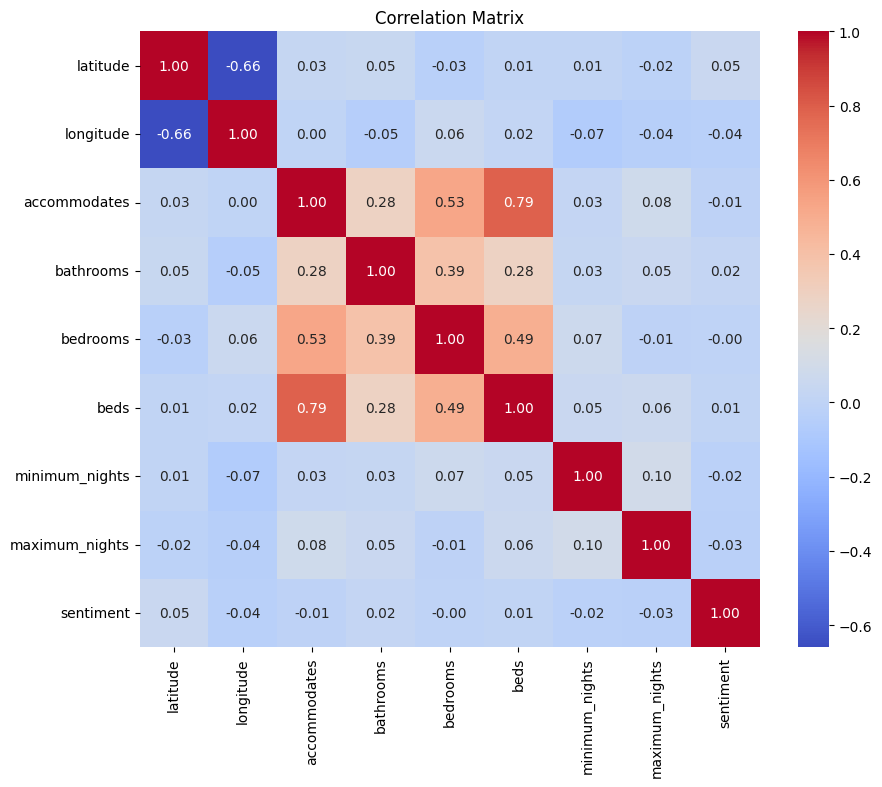

In [44]:
# Correlation matrix

#Converting price to float
if encoded_df['price'].dtype == 'object':
    encoded_df['price'] = encoded_df['price'].str.replace('[\$,]', '', regex=True).astype(float)
else:
    print("The 'price' column is already numeric. Skipping string conversion.")

independent_columns = encoded_df[important_columns]
corr_matrix = independent_columns.corr()

# # Calculate the correlation matrix using the filtered columns
# corr_matrix = encoded_df[correlation_columns].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Columns like longitude and latitude are highly negatively correlated. We will remove one of them.

Also, any columns that have high positive correlation need to be dealt with.

In [45]:
# delete longitude
independent_columns = independent_columns.drop(['longitude'], axis=1)

# delete beds, accomodates, and bathrooms
independent_columns = independent_columns.drop(['beds', 'accommodates','bathrooms'], axis=1)

# # delete accommodates
# independent_columns = independent_columns.drop(['accommodates'], axis=1)

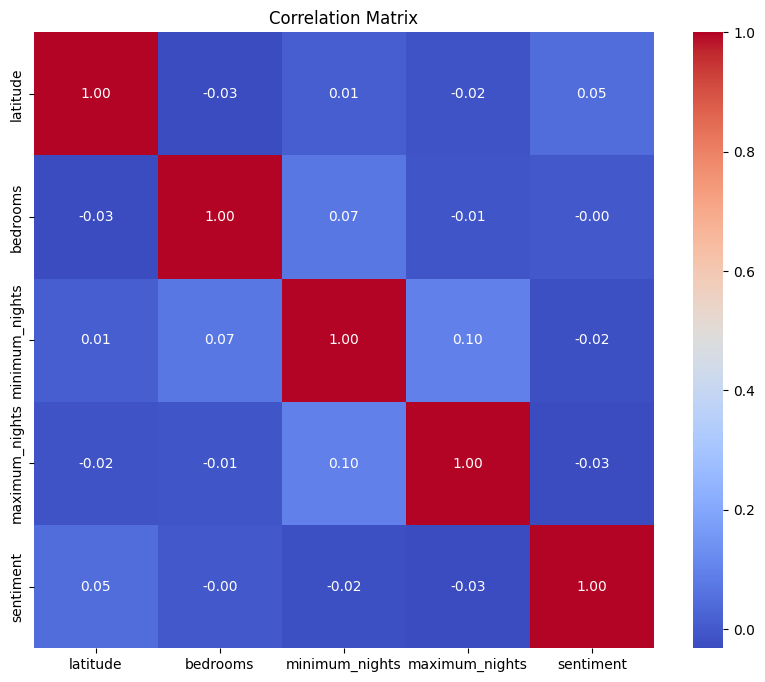

In [46]:
corr_matrix = independent_columns.corr()

plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [47]:
independent_columns.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,868.0,-34.590670,0.015965,-34.65539,-34.599972,-34.589384,-34.581313,-34.53726
bedrooms,868.0,0.972350,0.656207,0.00000,1.000000,1.000000,1.000000,4.00000
minimum_nights,868.0,2.993088,5.552098,1.00000,1.000000,2.000000,3.000000,100.00000
maximum_nights,868.0,485.365207,449.777206,2.00000,65.000000,365.000000,1125.000000,1125.00000
sentiment,868.0,0.457167,0.251119,-0.70000,0.327083,0.450000,0.600000,1.00000


In [48]:
y.describe().T

,price
count,868.000000
mean,32652.612903
std,13940.500828
min,8572.000000
25%,23004.500000
50%,28772.000000
75%,38766.000000
max,78344.000000


**Comparative Regression Model for Price Prediction**

In [49]:
# X = independent_columns
X = encoded_df.drop('price', axis=1)
y = encoded_df['price']
# y has already been defined above

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

# Scale numerical features using StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

In [50]:
# Define models and their hyperparameter grids for tuning
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Decision Tree': (DecisionTreeRegressor(random_state=42), {'max_depth': [None, 5, 10, 20]}),
    'Random Forest': (RandomForestRegressor(random_state=42), {'n_estimators': [None, 300, 700], 'max_depth': [None, 3, 5, 7, 10]}),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]}),
    'XGBoost': (xgb.XGBRegressor(random_state=42), {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]})
}

In [51]:
# Train and evaluate models
results = []
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train_scaled, y_train_scaled)

    # Predict on test set
    y_pred_scaled = grid_search.predict(X_test_scaled)

    # Inverse transform predictions and test target for evaluation
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
    r2 = r2_score(y_test_original, y_pred)

    results.append([model_name, rmse, r2, grid_search.best_params_])

In [52]:
# Display results
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R-squared', 'Best Parameters'])
results_df

,Model,RMSE,R-squared,Best Parameters
0,Linear Regression,1.103225e+16,-5.046697e+23,{}
1,Decision Tree,1.158292e+04,4.436928e-01,{'max_depth': 5}
2,Random Forest,1.108154e+04,4.908111e-01,"{'max_depth': 7, 'n_estimators': 700}"
3,Gradient Boosting,1.129739e+04,4.707819e-01,"{'learning_rate': 0.05, 'n_estimators': 100}"
4,XGBoost,1.162874e+04,4.392824e-01,"{'learning_rate': 0.05, 'n_estimators': 100}"


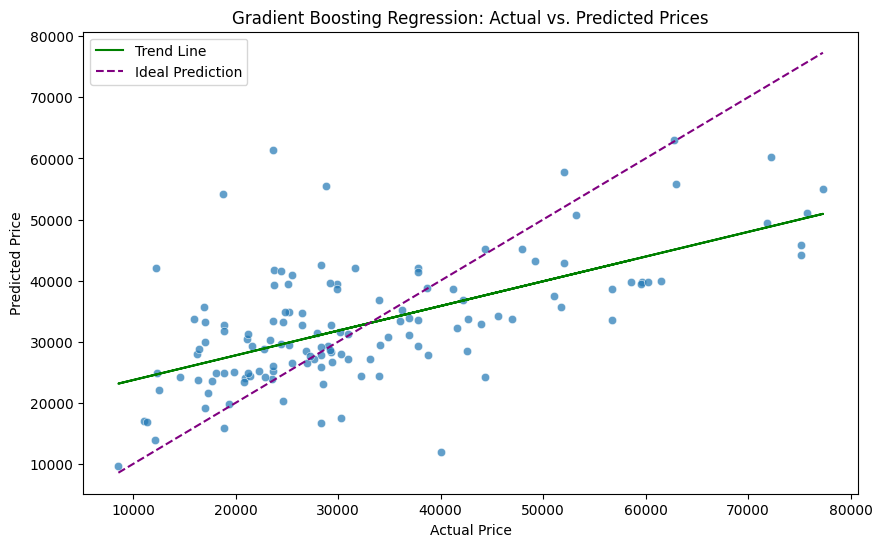

In [53]:
#Visualizing the model using a scatter plot and ideal prediction line
model_best = GradientBoostingRegressor(n_estimators=300, max_depth=5, random_state=42)
model_best.fit(X_train_scaled, y_train_scaled)

y_pred_scaled = model_best.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_original, y=y_pred, alpha=0.7)

z = np.polyfit(y_test_original, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test_original, p(y_test_original), color='green', linestyle='-', label='Trend Line')

# Add a diagonal line (ideal prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='purple', linestyle='--', label='Ideal Prediction')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Gradient Boosting Regression: Actual vs. Predicted Prices")
plt.legend()
plt.show()

In [55]:
y.describe().T

,price
count,868.000000
mean,32652.612903
std,13940.500828
min,8572.000000
25%,23004.500000
50%,28772.000000
75%,38766.000000
max,78344.000000
